In [30]:
import pandas as pd
from glob import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

checkpoints_dir = './checkpoints'
checkpoint_csv_files = glob(os.path.join(checkpoints_dir, '*-errorAnalysis.csv'))

print(checkpoint_csv_files)

['./checkpoints/openai-gpt-5-mini:fullPrompt:openrouter-errorAnalysis.csv', './checkpoints/openai-gpt-5-mini:simplePrompt:openrouter-errorAnalysis.csv']


In [31]:
df = pd.DataFrame()
for f in checkpoint_csv_files:
    sub_df = pd.read_csv(f)
    df = pd.concat([df, sub_df], ignore_index=True)



In [32]:
print(df.columns)
print(df.shape)

Index(['langgraph_thread_id', 'combined_name', 'model_name', 'provider',
       'trial_number', 'prompt_type', 'variant_type', 'nnz_flop_state',
       'top_p', 'temp', 'source_code', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'raw_flop_counts', 'predicted_sp_flop_count',
       'predicted_dp_flop_count', 'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'generic_model_name', 'has_nz_flops', 'percent_diff_sp',
       'percent_diff_dp', 'manualErrorClassification'],
      dtype='object')
(1254, 34)


In [33]:
print(df[df['combined_name'] == '(testSNAP-cuda, compute_yi)']['manualErrorClassification'].values)

['has DD-warp divergence;incorrect global function input arg(s);missing header file with necessary code/values'
 'has DD-warp divergence;incorrect global function input arg(s);missing header file with necessary code/values'
 'has DD-warp divergence;incorrect global function input arg(s);missing header file with necessary code/values'
 'has DD-warp divergence;incorrect global function input arg(s);missing header file with necessary code/values'
 nan
 'has DD-warp divergence;incorrect global function input arg(s);missing header file with necessary code/values'
 'has DD-warp divergence;incorrect global function input arg(s);missing header file with necessary code/values'
 nan
 'has DD-warp divergence;incorrect global function input arg(s);missing header file with necessary code/values'
 'has DD-warp divergence;incorrect global function input arg(s);missing header file with necessary code/values'
 'has DD-warp divergence;incorrect global function input arg(s);missing header file with neces

In [34]:
erroneous_cases = df[~df['manualErrorClassification'].isna()].copy()
print(erroneous_cases['manualErrorClassification'].shape)

(98,)


In [35]:
target_percent = 50
check_df = df[(df['percent_diff_sp'] > target_percent) | (df['percent_diff_dp'] > target_percent) | (df['percent_diff_sp'] < -target_percent) | (df['percent_diff_dp'] < -target_percent)]

assert erroneous_cases.shape[0] == check_df.shape[0]
assert erroneous_cases['langgraph_thread_id'].equals(check_df['langgraph_thread_id'])

In [36]:

# gather all the manualErrorClassification values and their counts
error_classes = set()

def scan_error_classes(errorStr):
    assert errorStr != None and errorStr != ''
    # split the errorStr by semicolon
    errors = errorStr.split(';')

    errors = ['uses half2 (FP16) precision reported as SP FLOPs' if 'uses half2 (FP16) precision' in err else err for err in errors]
    errors = ['incorrect global function input arg(s)' if '__global__' in err else err for err in errors]
    errors = ['typedef compiler arg not provided' if 'typedef compiler arg' in err else err for err in errors]

    error_classes.update([e.strip() for e in errors if e.strip() != ''])

    return ';'.join(errors)

erroneous_cases['manualErrorClassification'] = erroneous_cases['manualErrorClassification'].apply(scan_error_classes)
print(f'Identified {len(error_classes)} unique error classes:')
for ec in error_classes:
    print(f' - {ec}')

Identified 16 unique error classes:
 - typedef compiler arg not provided
 - missing header file with necessary code/values
 - missing input arg needed from input file
 - code comments made LLM assume X ops were taking place
 - has common sub-expressions
 - mistook exe args as a function input arg
 - has FP division
 - flop count explanation and reported value DIFFER
 - typedef float/double flipped
 - summed all execution instead of just first
 - has special math function
 - has DD-warp divergence
 - uses half2 (FP16) precision reported as SP FLOPs
 - incorrect global function input arg(s)
 - reported same count for both SP+DP
 - treated sign flip as 0 FLOP


In [37]:

for ec in error_classes:
    ec_str = ec
    print(f' - {ec_str}')
    erroneous_cases[ec_str] = erroneous_cases['manualErrorClassification'].apply(lambda x: True if ec in x else False)


error_classes = sorted(list(set(list(error_classes))))
print(erroneous_cases.columns)






 - typedef compiler arg not provided
 - missing header file with necessary code/values
 - missing input arg needed from input file
 - code comments made LLM assume X ops were taking place
 - has common sub-expressions
 - mistook exe args as a function input arg
 - has FP division
 - flop count explanation and reported value DIFFER
 - typedef float/double flipped
 - summed all execution instead of just first
 - has special math function
 - has DD-warp divergence
 - uses half2 (FP16) precision reported as SP FLOPs
 - incorrect global function input arg(s)
 - reported same count for both SP+DP
 - treated sign flip as 0 FLOP
Index(['langgraph_thread_id', 'combined_name', 'model_name', 'provider',
       'trial_number', 'prompt_type', 'variant_type', 'nnz_flop_state',
       'top_p', 'temp', 'source_code', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'raw_flop_counts', 'predicted_sp_flop_count

incorrect global function input arg(s)                   50
mistook exe args as a function input arg                 29
missing header file with necessary code/values           21
treated sign flip as 0 FLOP                              10
has DD-warp divergence                                    9
has special math function                                 9
missing input arg needed from input file                  8
code comments made LLM assume X ops were taking place     7
has FP division                                           7
uses half2 (FP16) precision reported as SP FLOPs          6
typedef compiler arg not provided                         4
typedef float/double flipped                              4
reported same count for both SP+DP                        3
has common sub-expressions                                2
flop count explanation and reported value DIFFER          1
summed all execution instead of just first                1
dtype: int64


<Axes: ylabel='None'>

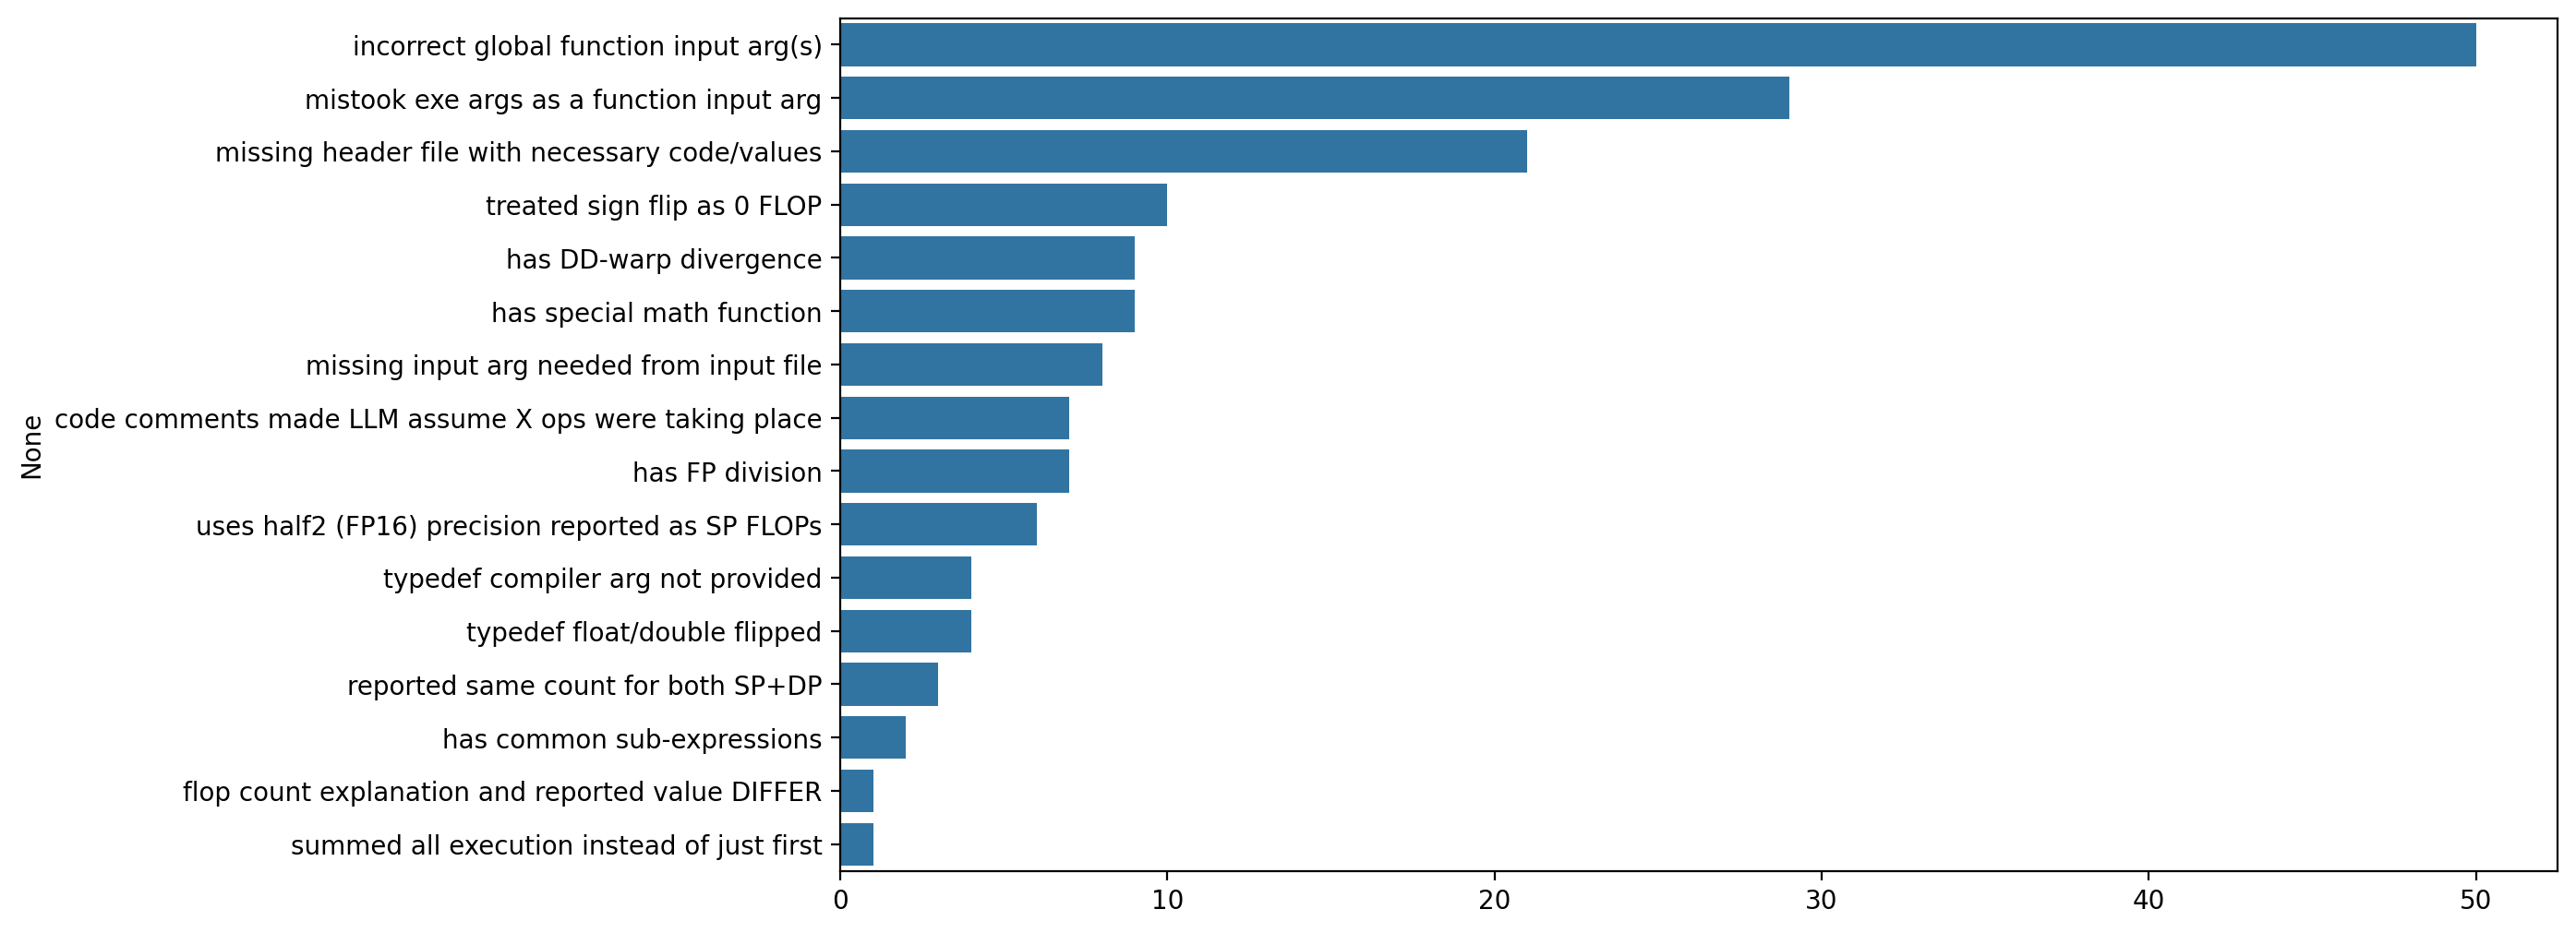

In [38]:
# let's visualize the distribution of error classes

fig, ax = plt.subplots(1,1 , figsize=(12, 6), dpi=200)

# get column True counts
counts = erroneous_cases[error_classes].sum().sort_values(ascending=False)

print(counts)

sns.barplot(y=counts.index, x=counts.values, ax=ax)


In [39]:
hard_code_features = ['has special math function', 
                      'has FP division', 
                      'has DD-warp divergence',
                      'has common sub-expressions']

hard_code_names = erroneous_cases[erroneous_cases[hard_code_features].any(axis=1)]['combined_name'].tolist()
hard_code_names = list(set(hard_code_names))

In [40]:
print(hard_code_names)

['(rodrigues-cuda, rotate2)', '(testSNAP-cuda, compute_yi)', '(attentionMultiHead-cuda, mha)']


In [ ]:
## ##DDe####ee3
:

                                    langgraph_thread_id  \
34    (attentionMultiHead-cuda, mha):openai/gpt-5-mi...   
36    (attentionMultiHead-cuda, mha):openai/gpt-5-mi...   
38    (attentionMultiHead-cuda, mha):openai/gpt-5-mi...   
665   (attentionMultiHead-cuda, mha):openai/gpt-5-mi...   
663   (attentionMultiHead-cuda, mha):openai/gpt-5-mi...   
661   (attentionMultiHead-cuda, mha):openai/gpt-5-mi...   
662   (attentionMultiHead-cuda, mha):openai/gpt-5-mi...   
537   (rodrigues-cuda, rotate2):openai/gpt-5-mini:ht...   
1164  (rodrigues-cuda, rotate2):openai/gpt-5-mini:ht...   
1214  (testSNAP-cuda, compute_yi):openai/gpt-5-mini:...   
1212  (testSNAP-cuda, compute_yi):openai/gpt-5-mini:...   
590   (testSNAP-cuda, compute_yi):openai/gpt-5-mini:...   
588   (testSNAP-cuda, compute_yi):openai/gpt-5-mini:...   
587   (testSNAP-cuda, compute_yi):openai/gpt-5-mini:...   
586   (testSNAP-cuda, compute_yi):openai/gpt-5-mini:...   
585   (testSNAP-cuda, compute_yi):openai/gpt-5-mini:... 

In [28]:
erroneous_cases = erroneous_cases[~erroneous_cases['combined_name'].isin(hard_code_names)].copy()
erroneous_case_ids = list(erroneous_cases['langgraph_thread_id'].unique())

print(erroneous_cases.columns)

Index(['langgraph_thread_id', 'combined_name', 'model_name', 'provider',
       'trial_number', 'prompt_type', 'variant_type', 'nnz_flop_state',
       'top_p', 'temp', 'source_code', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'raw_flop_counts', 'predicted_sp_flop_count',
       'predicted_dp_flop_count', 'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'generic_model_name', 'has_nz_flops', 'percent_diff_sp',
       'percent_diff_dp', 'manualErrorClassification',
       'typedef compiler arg not provided',
       'missing header file with necessary code/values',
       'missing input arg needed from input file',
       'code comments made LLM assume X ops were taking place',
       'has common sub-expressions',
       'mistook exe args as a fu

In [16]:
dataset_design_errors = ['missing header file with necessary code/values', 
                         'missing input arg needed from input file', 
                         'typedef compiler arg not provided', 
                         'typedef float/double flipped']


design_error_names = erroneous_cases[erroneous_cases[dataset_design_errors].any(axis=1)]['combined_name'].tolist()
design_error_names = list(set(design_error_names))
print(f'Identified {len(design_error_names)} unique dataset design error cases:')
print(design_error_names)
print(len(design_error_names))
print(erroneous_cases[erroneous_cases[dataset_design_errors].any(axis=1)].sort_values(by='combined_name'))

total_mispred_names = erroneous_cases['combined_name'].nunique()
print(total_mispred_names)

missing_file_data_errors = ['missing header file with necessary code/values', 
                            'missing input arg needed from input file']
print('\nMissing necessary file/data errors:')

missing_file_data_names = erroneous_cases[erroneous_cases[missing_file_data_errors].any(axis=1)]['combined_name'].tolist()
missing_file_data_names = list(set(missing_file_data_names))
print(f'Identified {len(missing_file_data_names)} unique missing file/data error cases:')
print(missing_file_data_names)

Identified 4 unique dataset design error cases:
['(adv-cuda, advCubatureHex3D)', '(gmm-cuda, mstep_means)', '(testSNAP-cuda, compute_deidrj)', '(gmm-cuda, mstep_N)']
4
                                    langgraph_thread_id  \
14    (adv-cuda, advCubatureHex3D):openai/gpt-5-mini...   
16    (adv-cuda, advCubatureHex3D):openai/gpt-5-mini...   
639   (adv-cuda, advCubatureHex3D):openai/gpt-5-mini...   
643   (adv-cuda, advCubatureHex3D):openai/gpt-5-mini...   
225   (gmm-cuda, mstep_N):openai/gpt-5-mini:https://...   
226   (gmm-cuda, mstep_N):openai/gpt-5-mini:https://...   
230   (gmm-cuda, mstep_N):openai/gpt-5-mini:https://...   
856   (gmm-cuda, mstep_N):openai/gpt-5-mini:https://...   
232   (gmm-cuda, mstep_means):openai/gpt-5-mini:http...   
236   (gmm-cuda, mstep_means):openai/gpt-5-mini:http...   
861   (gmm-cuda, mstep_means):openai/gpt-5-mini:http...   
859   (gmm-cuda, mstep_means):openai/gpt-5-mini:http...   
1209  (testSNAP-cuda, compute_deidrj):openai/gpt-5-m...   
1208  

                                          Error Class Prompt Type  Num Samples
0   code comments made LLM assume X ops were takin...        full            5
1   code comments made LLM assume X ops were takin...      simple            2
2    flop count explanation and reported value DIFFER        full            1
3    flop count explanation and reported value DIFFER      simple            0
4                              has DD-warp divergence        full            0
5                              has DD-warp divergence      simple            0
6                                     has FP division        full            0
7                                     has FP division      simple            0
8                          has common sub-expressions        full            0
9                          has common sub-expressions      simple            0
10                          has special math function        full            0
11                          has special math functio

Text(0.5, 0, 'Sample Count')

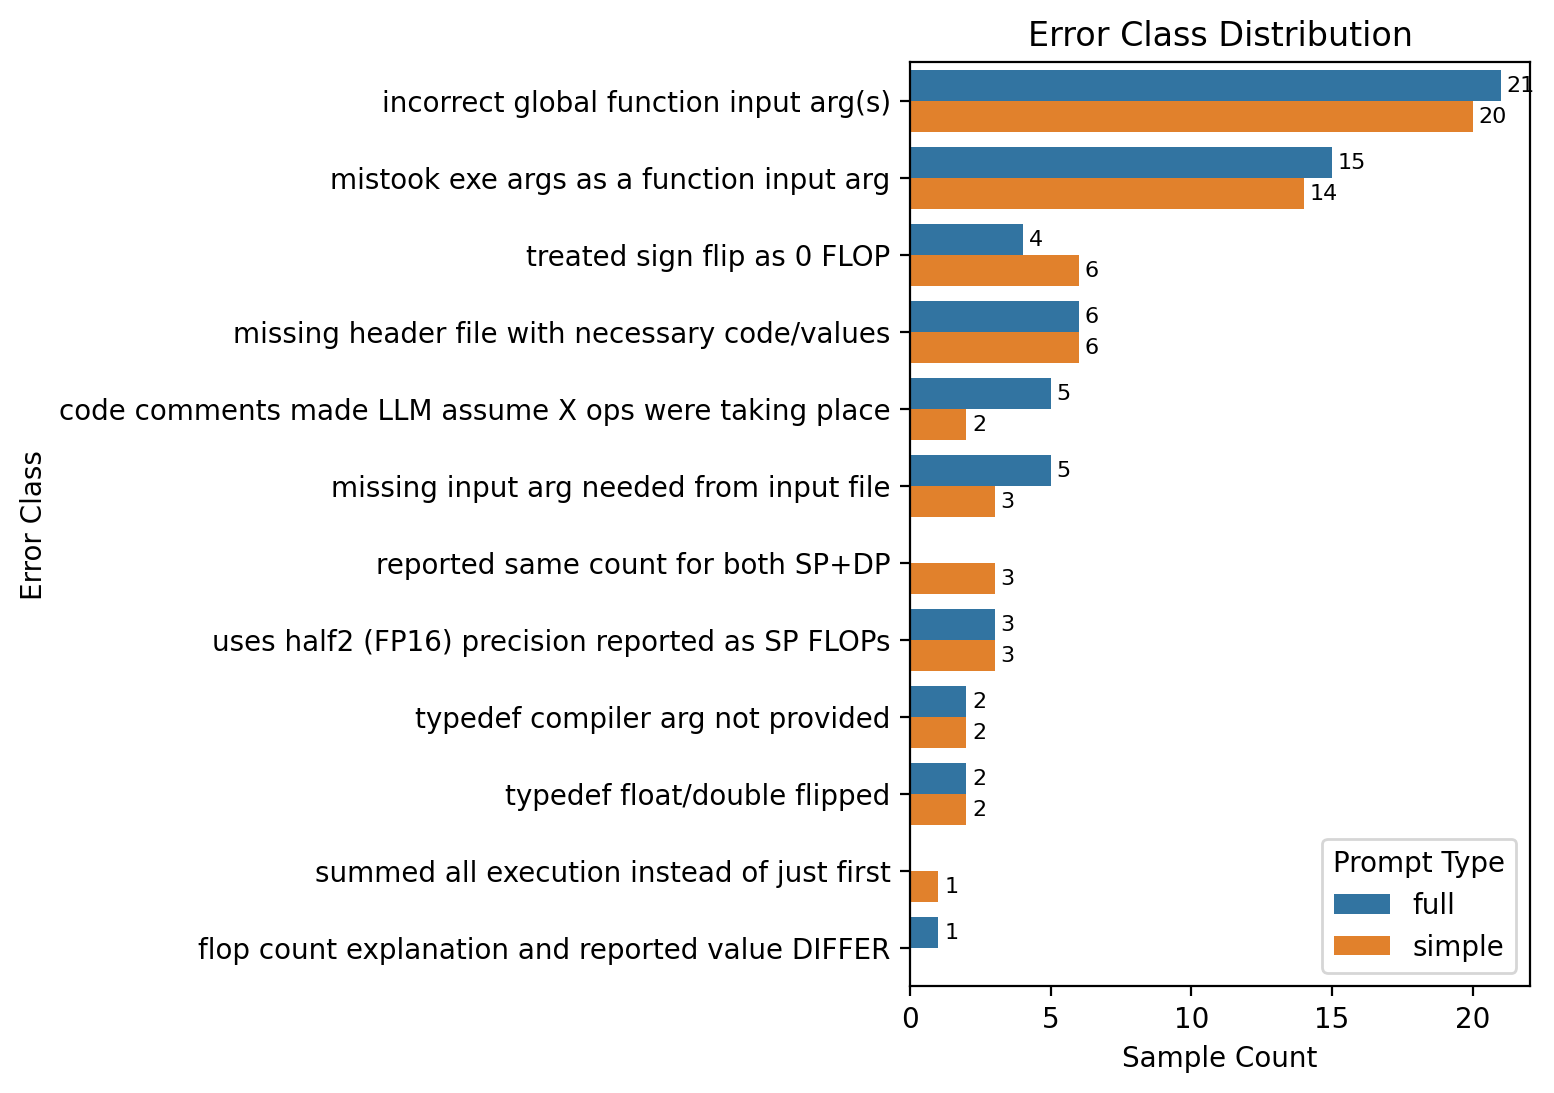

In [14]:
fig, ax = plt.subplots(1,1 , figsize=(4, 6), dpi=200)

# transpose counts
counts = erroneous_cases.groupby(by=['prompt_type'])[error_classes].sum().unstack().reset_index()
counts.columns = ['Error Class', 'Prompt Type', 'Num Samples']

print(counts)
print('cols', counts.columns)

# drop counts that are zero
counts = counts[counts['Num Samples'] > 0]

counts = counts.sort_values(by=['Num Samples'], ascending=False)
#
#print(counts)
#print(counts.sum())
#
## print the percentages
#for error_class, count in counts.items():
#    percent = 100 * count / counts.sum()
#    print(f'{error_class.ljust(60)}: {count} ({percent:.2f}%)')

sns.barplot(y=counts['Error Class'], x=counts['Num Samples'], hue=counts['Prompt Type'], ax=ax)

# annotate the bars with counts
# When hue is used, seaborn draws grouped bars. We'll loop over the patches to place labels on each bar.
for p in ax.patches:
    # p.get_width() is the bar length (count) since bars are horizontal
    width = p.get_width()
    if width == 0:
        continue
    # get bar center y coordinate
    y = p.get_y() + p.get_height() / 2
    ax.text(width + max(counts['Num Samples']) * 0.01, y, str(int(width)), va='center', ha='left', fontsize=8)

ax.set_title('Error Class Distribution')
ax.set_ylabel('Error Class')
ax.set_xlabel('Sample Count')

incorrect global function input arg(s)                   41
mistook exe args as a function input arg                 29
missing header file with necessary code/values           12
treated sign flip as 0 FLOP                              10
missing input arg needed from input file                  8
code comments made LLM assume X ops were taking place     7
uses half2 (FP16) precision reported as SP FLOPs          6
typedef compiler arg not provided                         4
typedef float/double flipped                              4
reported same count for both SP+DP                        3
flop count explanation and reported value DIFFER          1
summed all execution instead of just first                1
dtype: int64
126
incorrect global function input arg(s)                      : 41 (32.54%)
mistook exe args as a function input arg                    : 29 (23.02%)
missing header file with necessary code/values              : 12 (9.52%)
treated sign flip as 0 FLOP               

Text(0.5, 0, 'Sample Count')

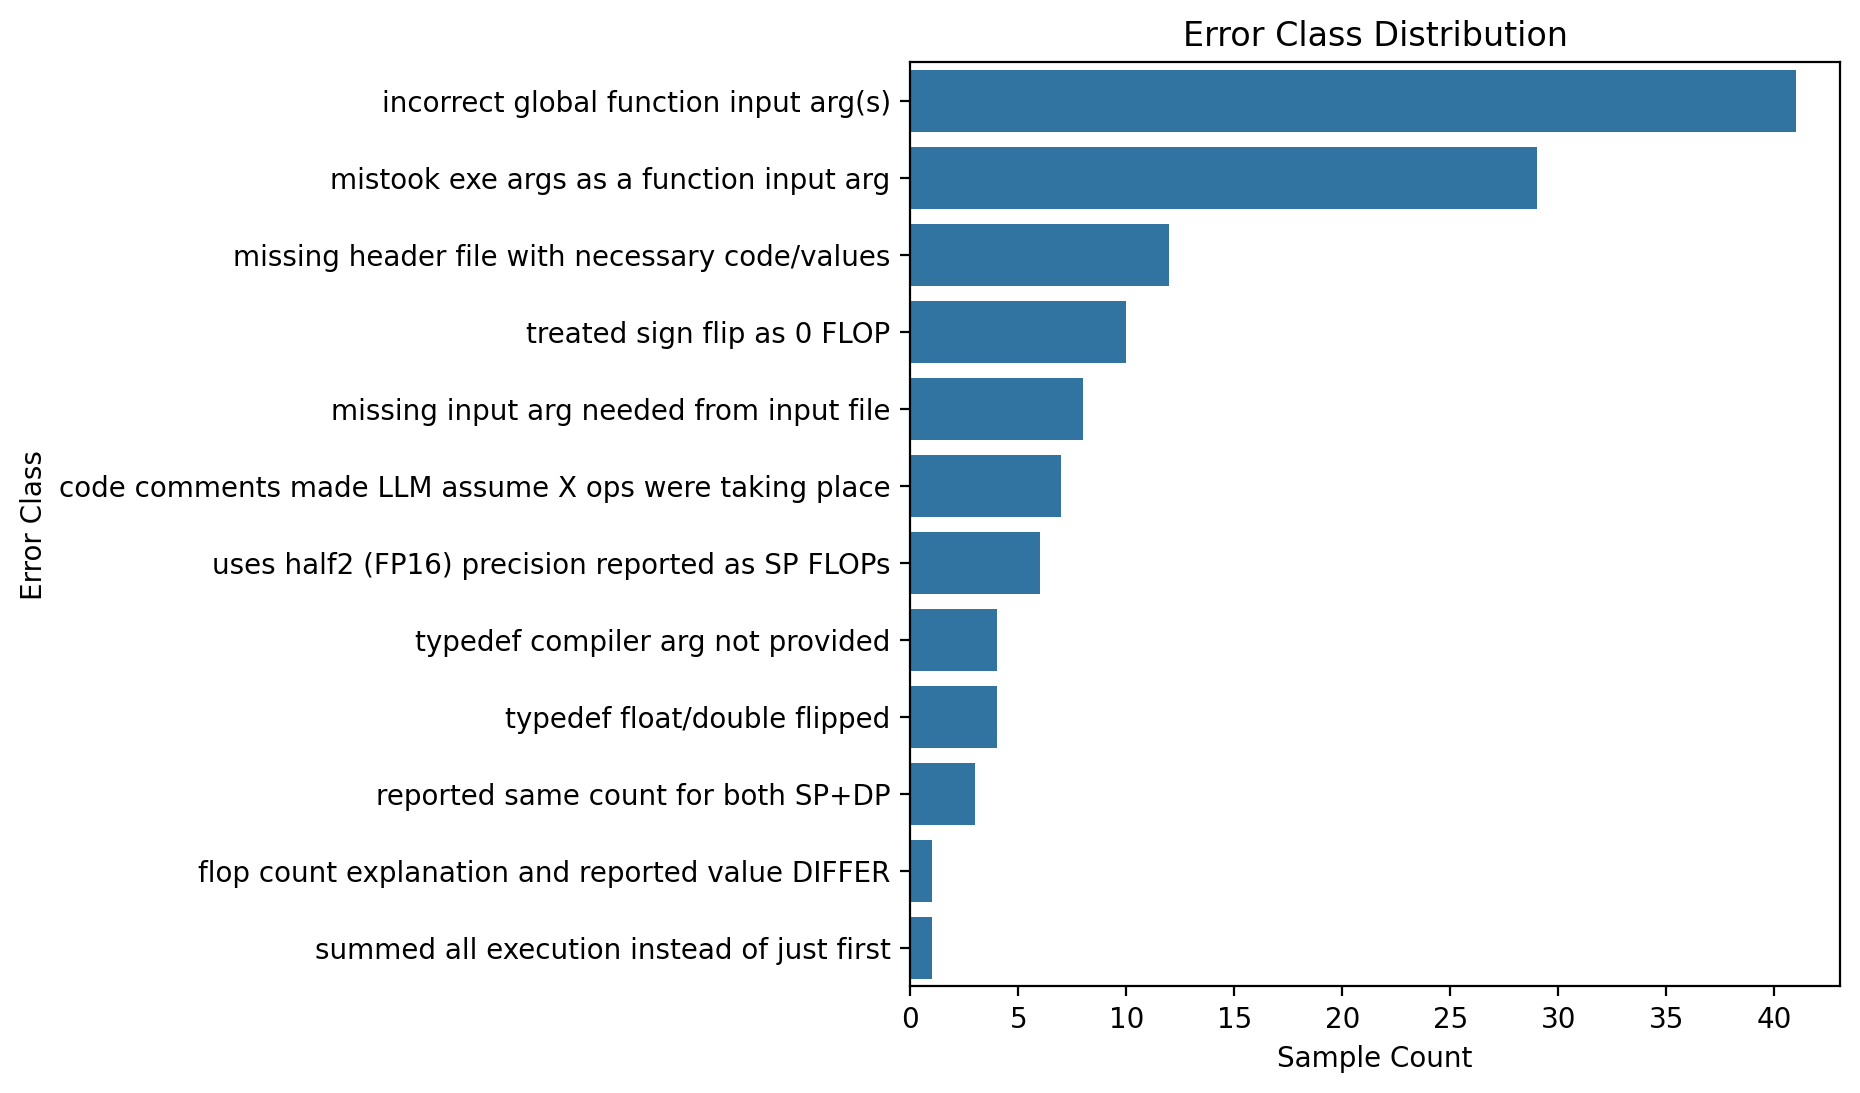

In [15]:

fig, ax = plt.subplots(1,1 , figsize=(6, 6), dpi=200)

# get column True counts
counts = erroneous_cases[error_classes].sum().sort_values(ascending=False)

# drop counts that are zero
counts = counts[counts > 0]

print(counts)
print(counts.sum())

# print the percentages
for error_class, count in counts.items():
    percent = 100 * count / counts.sum()
    print(f'{error_class.ljust(60)}: {count} ({percent:.2f}%)')

sns.barplot(y=counts.index, x=counts.values, ax=ax)

ax.set_title('Error Class Distribution')
ax.set_ylabel('Error Class')
ax.set_xlabel('Sample Count')

In [16]:
# drop the hard_code_names from the df
df = df[~df['combined_name'].isin(hard_code_names)].copy()

print(df['prompt_type'].value_counts())
print(df.shape)

prompt_type
full      609
simple    609
Name: count, dtype: int64
(1218, 34)


In [17]:
def plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple', show_erroneous=True):
    sub_df = df[(df['generic_model_name'] == model_name) & (df['prompt_type'] == prompt_type)]
    success_df = sub_df[(sub_df['error'] == 'Success')]

    print(f'Success DF Size: {success_df.shape}')
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

    max_sp_dp_flop = max(
        success_df['empirical_sp_flop_count'].max(),
        success_df['empirical_dp_flop_count'].max(),
        success_df['predicted_sp_flop_count'].max(),
        success_df['predicted_dp_flop_count'].max()
    )
    min_sp_dp_flop = min(
        success_df['empirical_sp_flop_count'].min(),
        success_df['empirical_dp_flop_count'].min(),
        success_df['predicted_sp_flop_count'].min(),
        success_df['predicted_dp_flop_count'].min()
    )

    # plot the x-y line on the plot
    ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

    sns.scatterplot(x='empirical_sp_flop_count', y='predicted_sp_flop_count', data=success_df, label='SP FLOP', alpha=0.5, ax=ax, color='orange')
    sns.scatterplot(x='empirical_dp_flop_count', y='predicted_dp_flop_count', data=success_df, label='DP FLOP', alpha=0.5, ax=ax, color='blue')
    # overlay erroneous cases in red with X marker for visibility
    err_df = sub_df[sub_df['langgraph_thread_id'].isin(erroneous_case_ids)]
    err_df_sp = err_df[(err_df['percent_diff_sp'] >= 50) | (err_df['percent_diff_sp'] <= -50)]
    err_df_dp = err_df[(err_df['percent_diff_dp'] >= 50) | (err_df['percent_diff_dp'] <= -50)]
    if not err_df.empty and show_erroneous:
        sns.scatterplot(x='empirical_sp_flop_count', y='predicted_sp_flop_count', data=err_df_sp, label='Mispredicted', alpha=0.9, ax=ax, color='red', marker='X', s=20)
        sns.scatterplot(x='empirical_dp_flop_count', y='predicted_dp_flop_count', data=err_df_dp, label='', alpha=0.9, ax=ax, color='red', marker='X', s=20)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(f'Baseline: LLM-Predicted vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt)')

    ax.set_xlabel('Actual/Profiled FLOP Count')
    ax.set_ylabel('LLM-Predicted FLOP Count')
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)

    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()

    ##############################################
    # let's print the CDF of the percent differences for SP and DP FLOP counts

    nnz_sp_data = success_df['percent_diff_sp']
    nnz_dp_data = success_df['percent_diff_dp']

    # let's make a cdf plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.ecdfplot(nnz_sp_data, label='SP FLOP', ax=ax, color='orange')
    sns.ecdfplot(nnz_dp_data, label='DP FLOP', ax=ax, color='blue')

    ax.set_xscale('symlog')
    #ax.set_yscale('log')
    ax.set_xlabel('Percent Difference (%)')
    ax.set_ylabel('Proportion of Data <= X')
    ax.legend()
    ax.set_title(f'CDF of Percent Differences \n({model_name} -- {prompt_type} prompt)')

    plt.tight_layout()
    plt.show()

    # let's make histograms of the total_cost, totalQueryTime, and failure cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

    sns.histplot(data=success_df, x='total_cost', hue='has_nz_flops', bins=50, ax=axs[0])
    axs[0].set_title('Query Cost Distribution')
    axs[0].set_xlabel('Query Cost ($ USD)')
    axs[0].set_ylabel('Frequency')
    axs[0].get_legend().set_title('Kernel has NZ FLOPs?')

    # rotate the x ticks for the query cost plot
    for label in axs[0].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


    sns.histplot(data=success_df, x='total_query_time', hue='has_nz_flops', bins=50, ax=axs[1])
    axs[1].set_title('Total Query Time Distribution')
    axs[1].set_xlabel('Total Query Time (seconds)')
    axs[1].set_ylabel('Frequency')
    axs[1].get_legend().set_title('Kernel has NZ FLOPs?')

    #error_value_counts = df['error'].value_counts()
    sns.countplot(data=sub_df, x='error', ax=axs[2])
    axs[2].set_title('Failure Cases Distribution')
    axs[2].set_xlabel('Failure Cases')
    axs[2].set_ylabel('Frequency')

    # add countplot values on top of the bars
    for p in axs[2].patches:
        axs[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    percents = [1, 5, 10, 50, 100]
    for perc in percents:
        num_sp_within_xpct = ((nnz_sp_data > -perc) & (nnz_sp_data < perc)).sum()
        num_sp_outside_xpct = ((nnz_sp_data <= -perc) | (nnz_sp_data >= perc)).sum()

        num_dp_within_xpct = ((nnz_dp_data > -perc) & (nnz_dp_data < perc)).sum()
        num_dp_outside_xpct = ((nnz_dp_data <= -perc) | (nnz_dp_data >= perc)).sum()

        total_sp = nnz_sp_data.shape[0]
        total_dp = nnz_dp_data.shape[0]

        print(f'SP FLOP: {num_sp_within_xpct} / {total_sp} ({100*num_sp_within_xpct/total_sp:.2f}%) within +/- {perc}%')
        print(f'SP FLOP: {num_sp_outside_xpct} / {total_sp} ({100*num_sp_outside_xpct/total_sp:.2f}%) outside +/- {perc}%')
        print(f'DP FLOP: {num_dp_within_xpct} / {total_dp} ({100*num_dp_within_xpct/total_dp:.2f}%) within +/- {perc}%')
        print(f'DP FLOP: {num_dp_outside_xpct} / {total_dp} ({100*num_dp_outside_xpct/total_dp:.2f}%) outside +/- {perc}%')
        print("\n")

    print("\n")

Success DF Size: (609, 34)


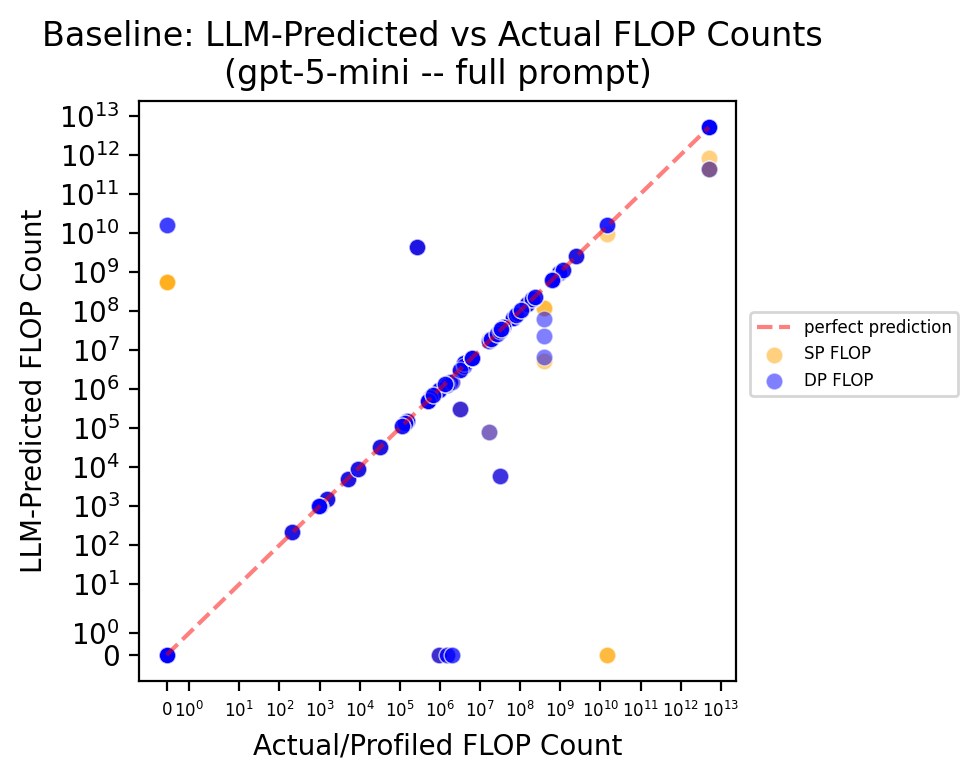

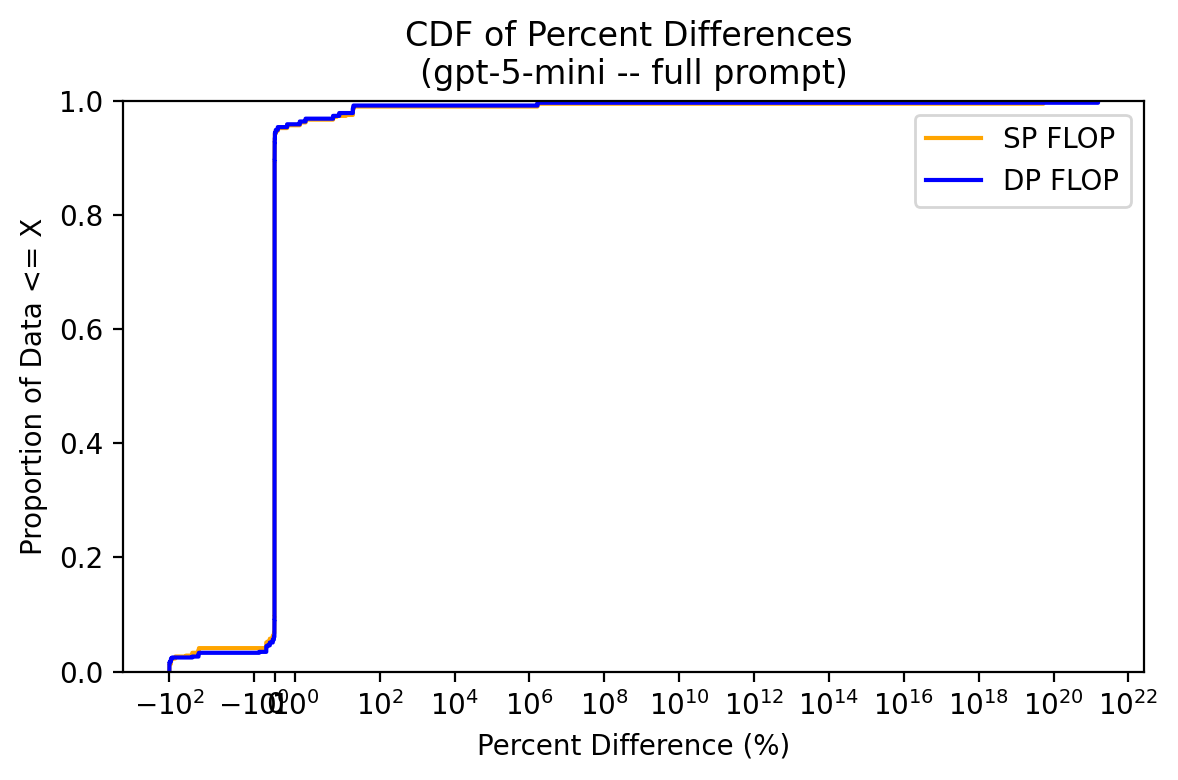

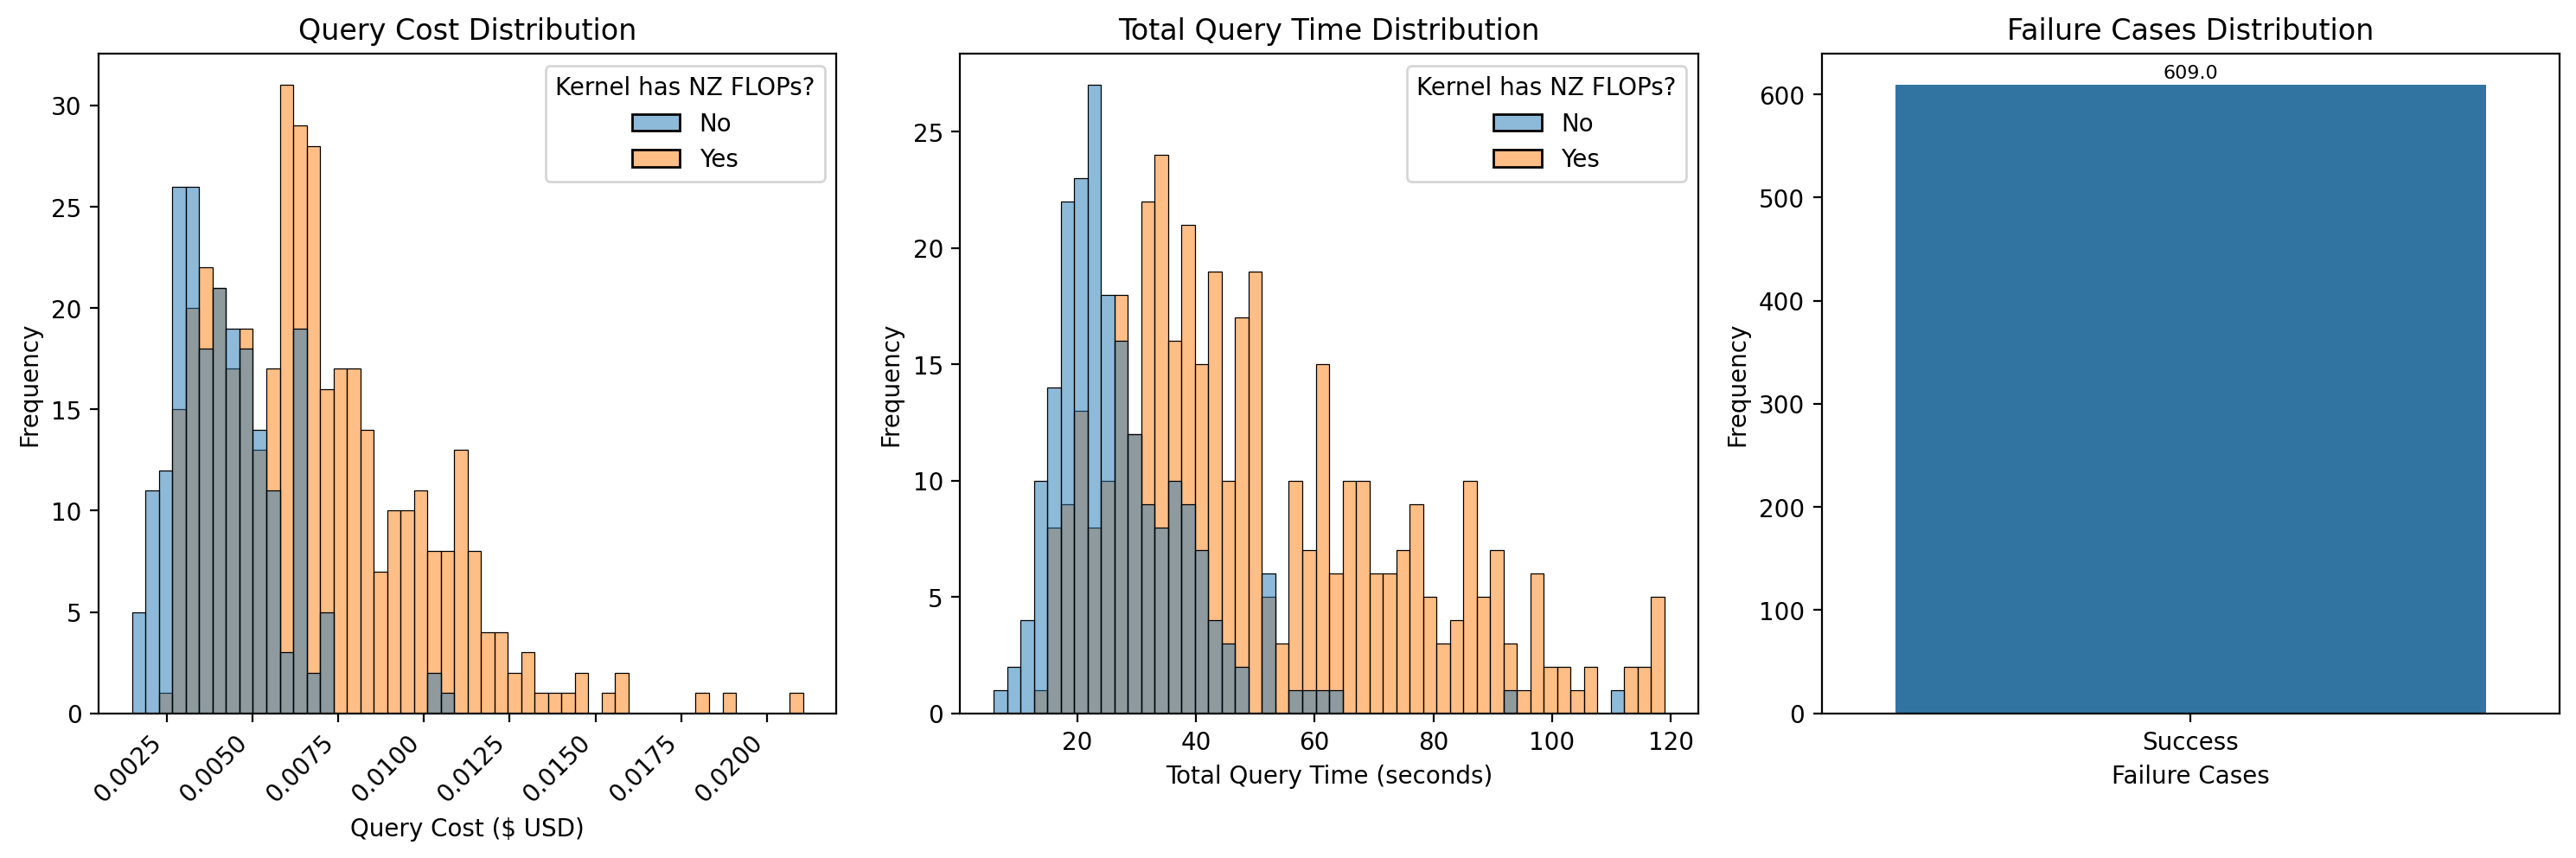

SP FLOP: 558 / 609 (91.63%) within +/- 1%
SP FLOP: 51 / 609 (8.37%) outside +/- 1%
DP FLOP: 564 / 609 (92.61%) within +/- 1%
DP FLOP: 45 / 609 (7.39%) outside +/- 1%


SP FLOP: 564 / 609 (92.61%) within +/- 5%
SP FLOP: 45 / 609 (7.39%) outside +/- 5%
DP FLOP: 570 / 609 (93.60%) within +/- 5%
DP FLOP: 39 / 609 (6.40%) outside +/- 5%


SP FLOP: 568 / 609 (93.27%) within +/- 10%
SP FLOP: 41 / 609 (6.73%) outside +/- 10%
DP FLOP: 576 / 609 (94.58%) within +/- 10%
DP FLOP: 33 / 609 (5.42%) outside +/- 10%


SP FLOP: 587 / 609 (96.39%) within +/- 50%
SP FLOP: 22 / 609 (3.61%) outside +/- 50%
DP FLOP: 589 / 609 (96.72%) within +/- 50%
DP FLOP: 20 / 609 (3.28%) outside +/- 50%


SP FLOP: 601 / 609 (98.69%) within +/- 100%
SP FLOP: 8 / 609 (1.31%) outside +/- 100%
DP FLOP: 604 / 609 (99.18%) within +/- 100%
DP FLOP: 5 / 609 (0.82%) outside +/- 100%




Success DF Size: (609, 34)


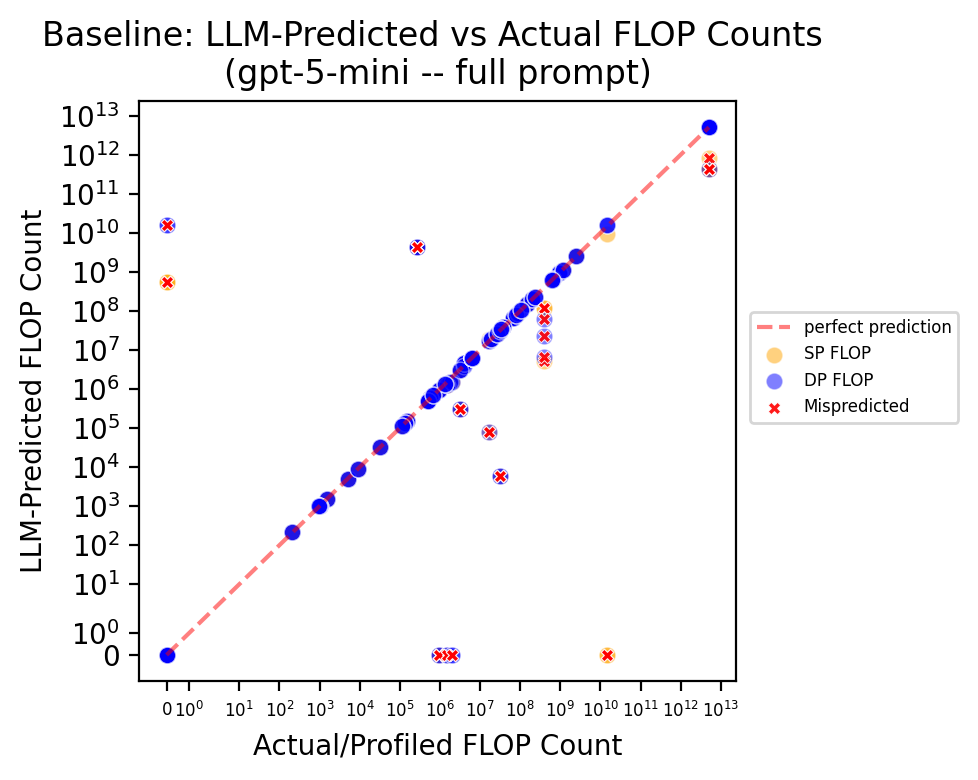

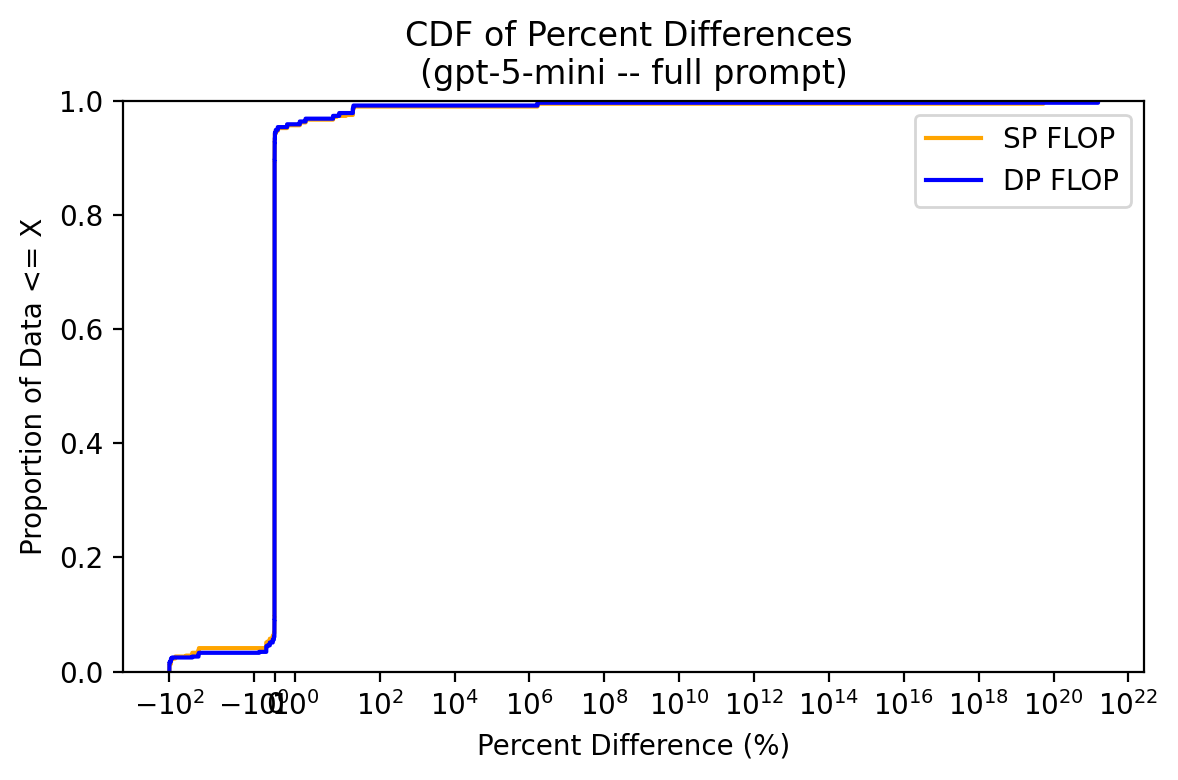

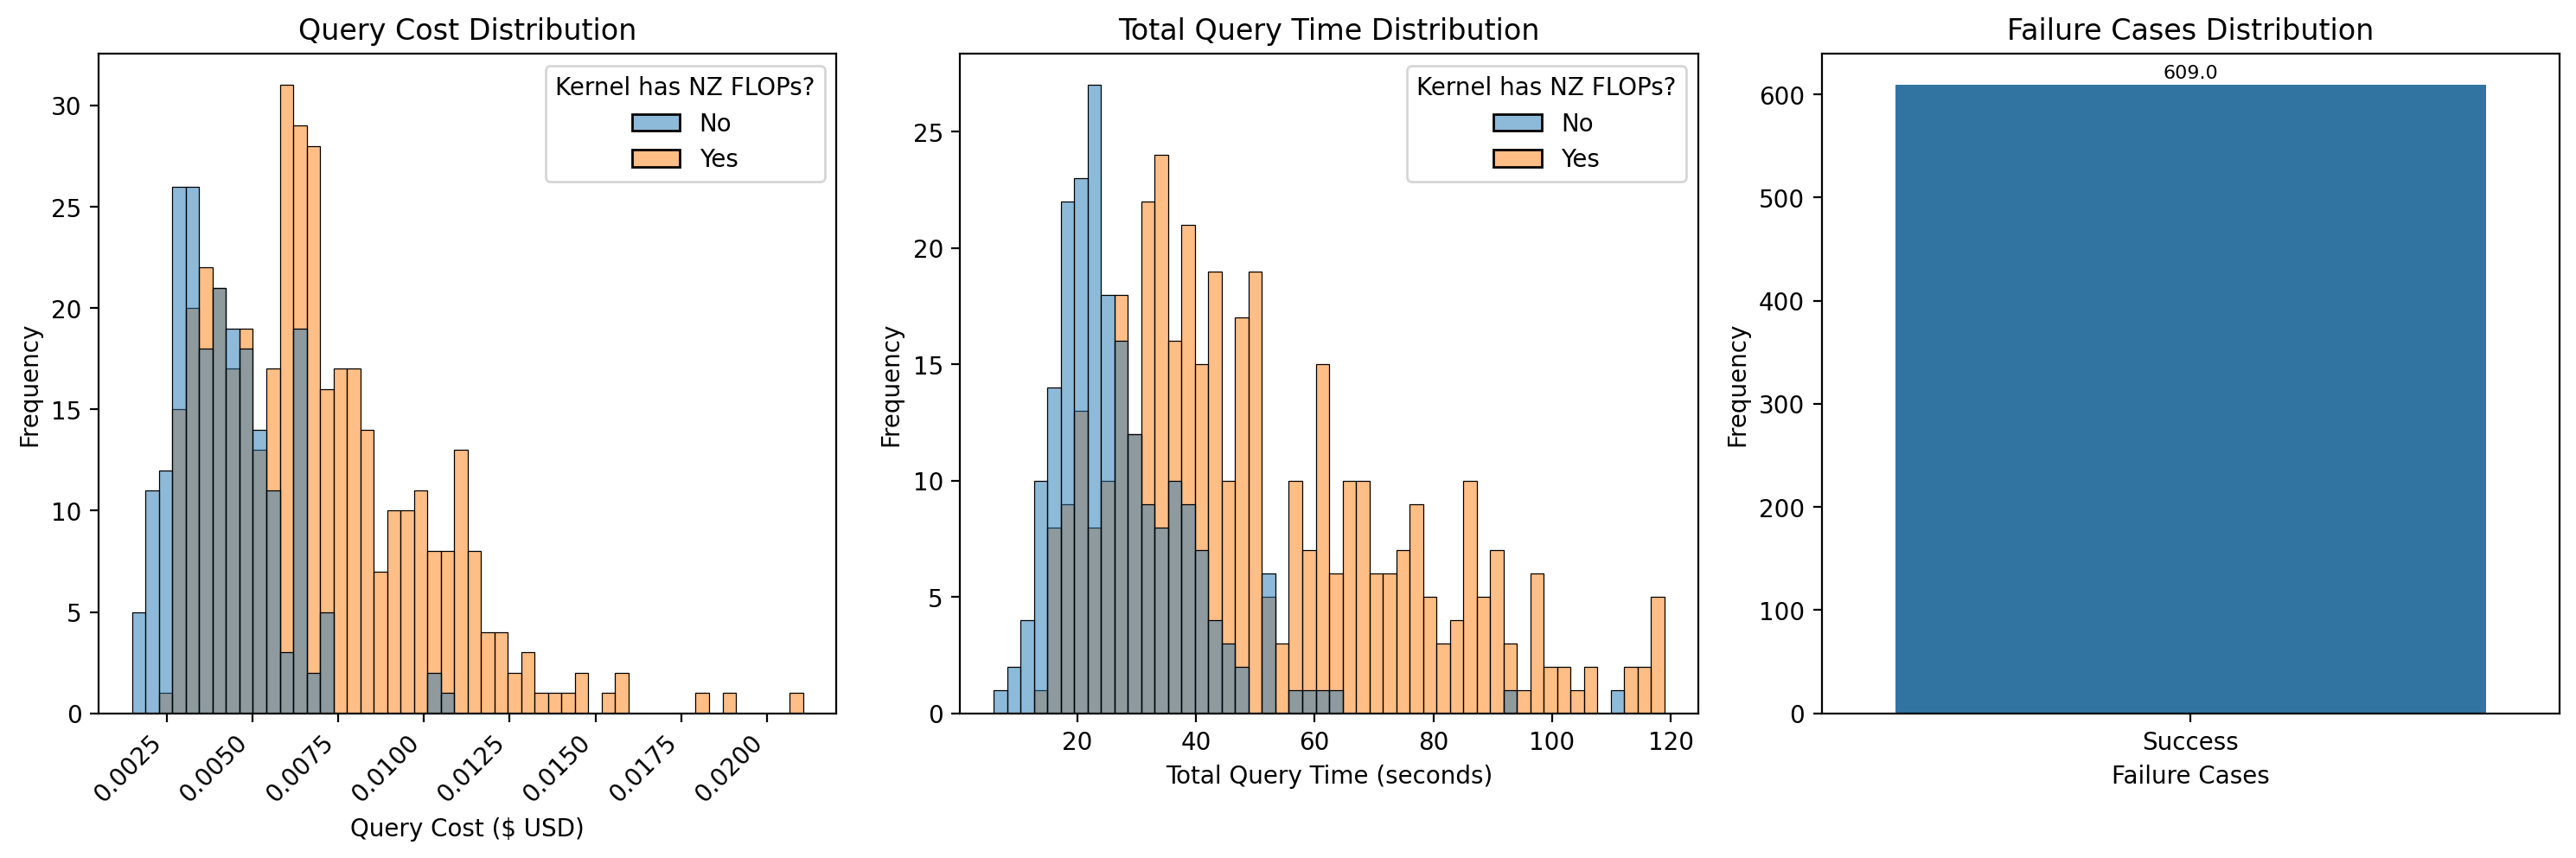

SP FLOP: 558 / 609 (91.63%) within +/- 1%
SP FLOP: 51 / 609 (8.37%) outside +/- 1%
DP FLOP: 564 / 609 (92.61%) within +/- 1%
DP FLOP: 45 / 609 (7.39%) outside +/- 1%


SP FLOP: 564 / 609 (92.61%) within +/- 5%
SP FLOP: 45 / 609 (7.39%) outside +/- 5%
DP FLOP: 570 / 609 (93.60%) within +/- 5%
DP FLOP: 39 / 609 (6.40%) outside +/- 5%


SP FLOP: 568 / 609 (93.27%) within +/- 10%
SP FLOP: 41 / 609 (6.73%) outside +/- 10%
DP FLOP: 576 / 609 (94.58%) within +/- 10%
DP FLOP: 33 / 609 (5.42%) outside +/- 10%


SP FLOP: 587 / 609 (96.39%) within +/- 50%
SP FLOP: 22 / 609 (3.61%) outside +/- 50%
DP FLOP: 589 / 609 (96.72%) within +/- 50%
DP FLOP: 20 / 609 (3.28%) outside +/- 50%


SP FLOP: 601 / 609 (98.69%) within +/- 100%
SP FLOP: 8 / 609 (1.31%) outside +/- 100%
DP FLOP: 604 / 609 (99.18%) within +/- 100%
DP FLOP: 5 / 609 (0.82%) outside +/- 100%




Success DF Size: (609, 34)


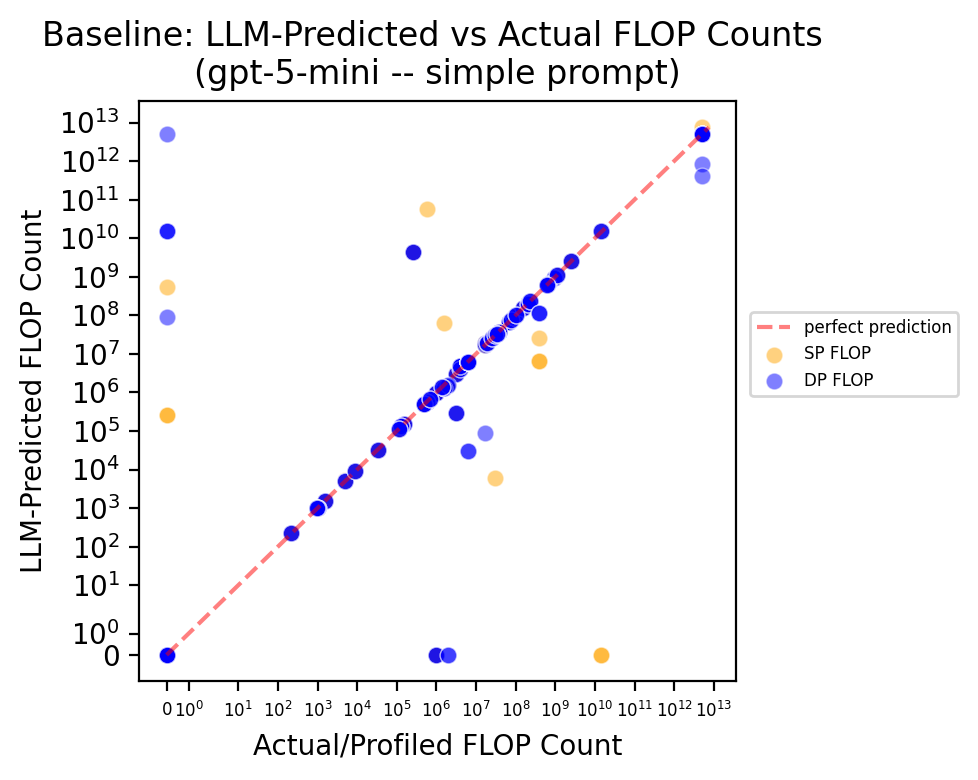

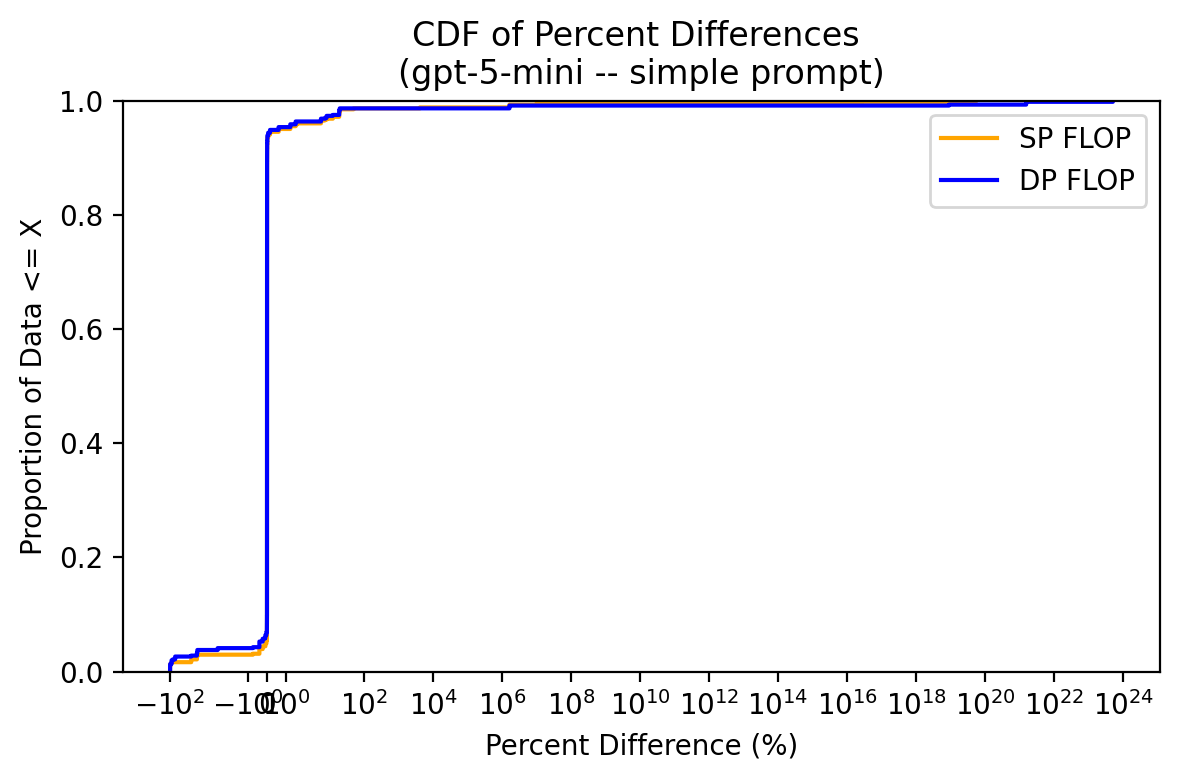

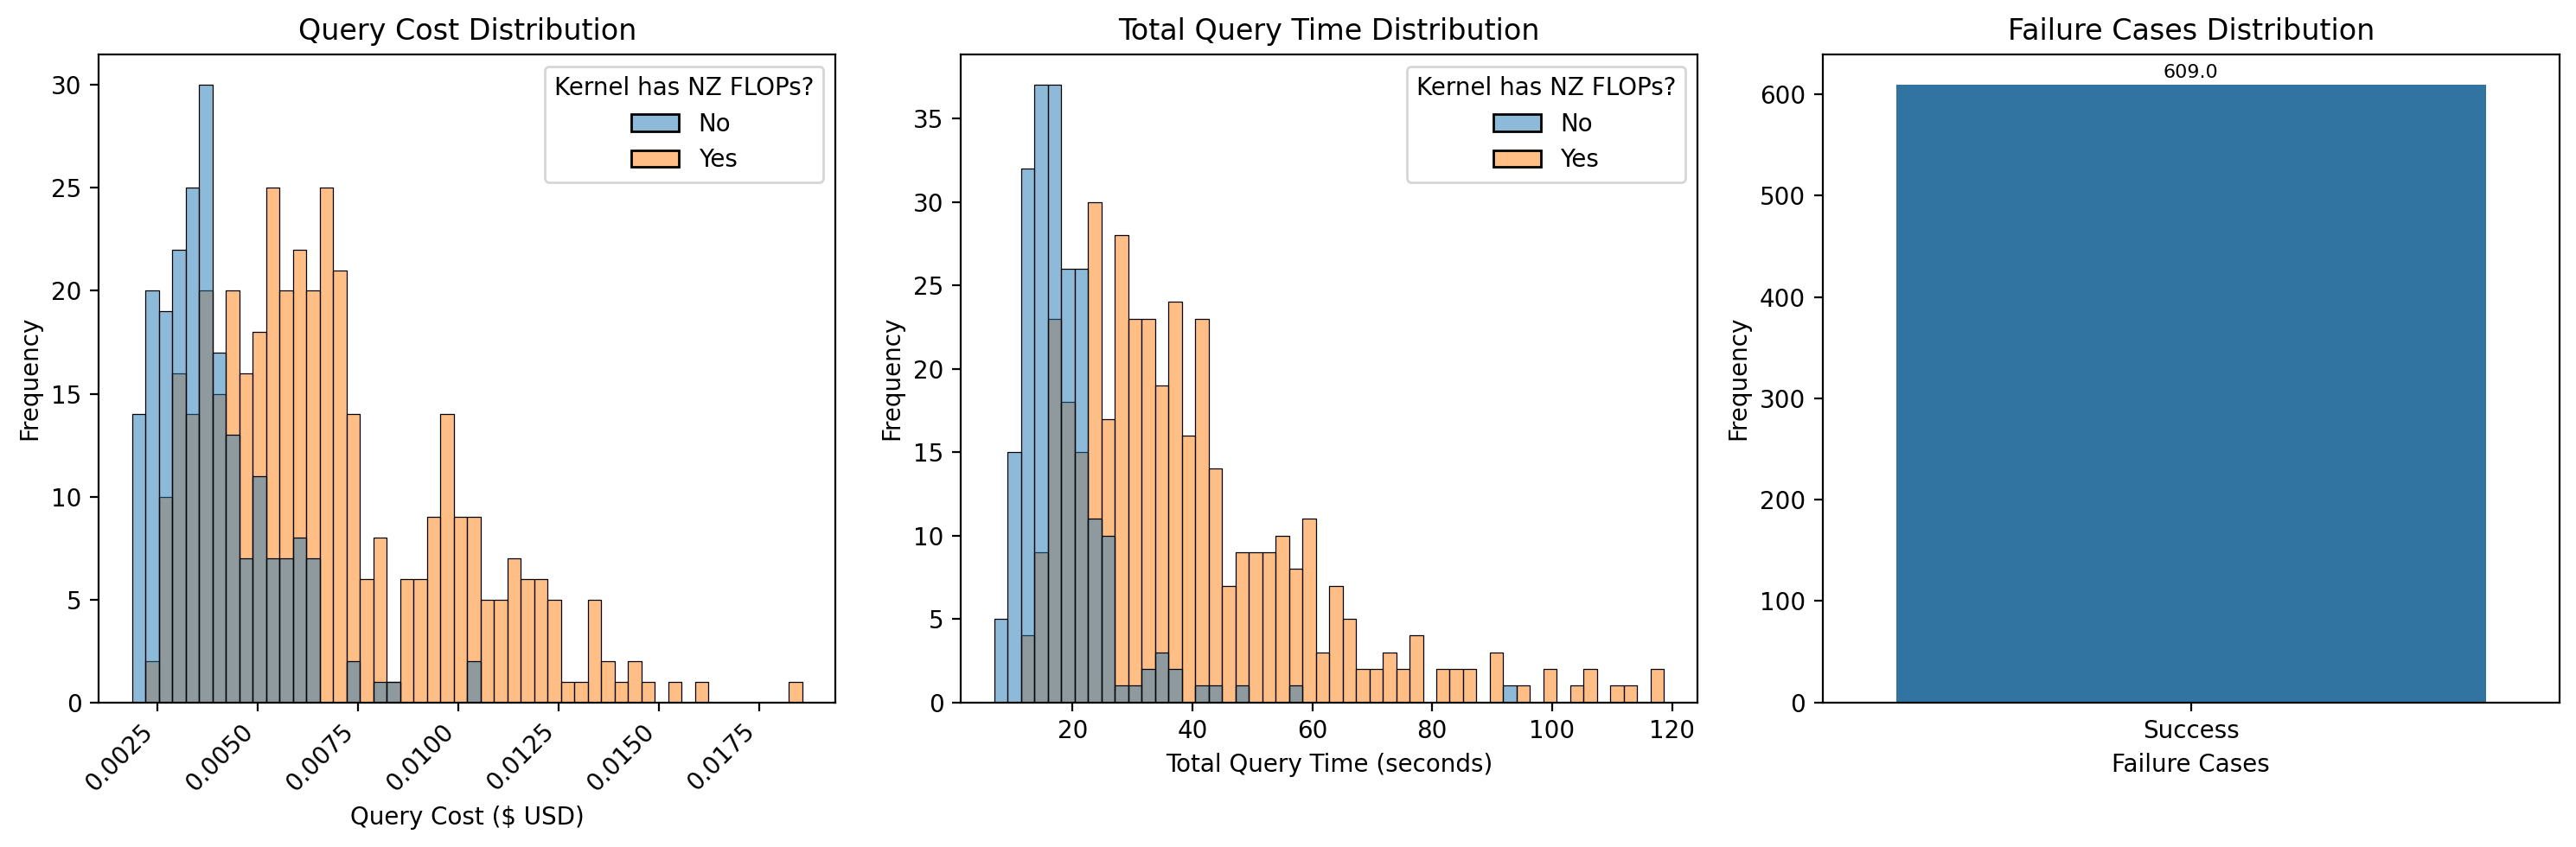

SP FLOP: 561 / 609 (92.12%) within +/- 1%
SP FLOP: 48 / 609 (7.88%) outside +/- 1%
DP FLOP: 556 / 609 (91.30%) within +/- 1%
DP FLOP: 53 / 609 (8.70%) outside +/- 1%


SP FLOP: 567 / 609 (93.10%) within +/- 5%
SP FLOP: 42 / 609 (6.90%) outside +/- 5%
DP FLOP: 564 / 609 (92.61%) within +/- 5%
DP FLOP: 45 / 609 (7.39%) outside +/- 5%


SP FLOP: 572 / 609 (93.92%) within +/- 10%
SP FLOP: 37 / 609 (6.08%) outside +/- 10%
DP FLOP: 570 / 609 (93.60%) within +/- 10%
DP FLOP: 39 / 609 (6.40%) outside +/- 10%


SP FLOP: 591 / 609 (97.04%) within +/- 50%
SP FLOP: 18 / 609 (2.96%) outside +/- 50%
DP FLOP: 585 / 609 (96.06%) within +/- 50%
DP FLOP: 24 / 609 (3.94%) outside +/- 50%


SP FLOP: 599 / 609 (98.36%) within +/- 100%
SP FLOP: 10 / 609 (1.64%) outside +/- 100%
DP FLOP: 601 / 609 (98.69%) within +/- 100%
DP FLOP: 8 / 609 (1.31%) outside +/- 100%




Success DF Size: (609, 34)


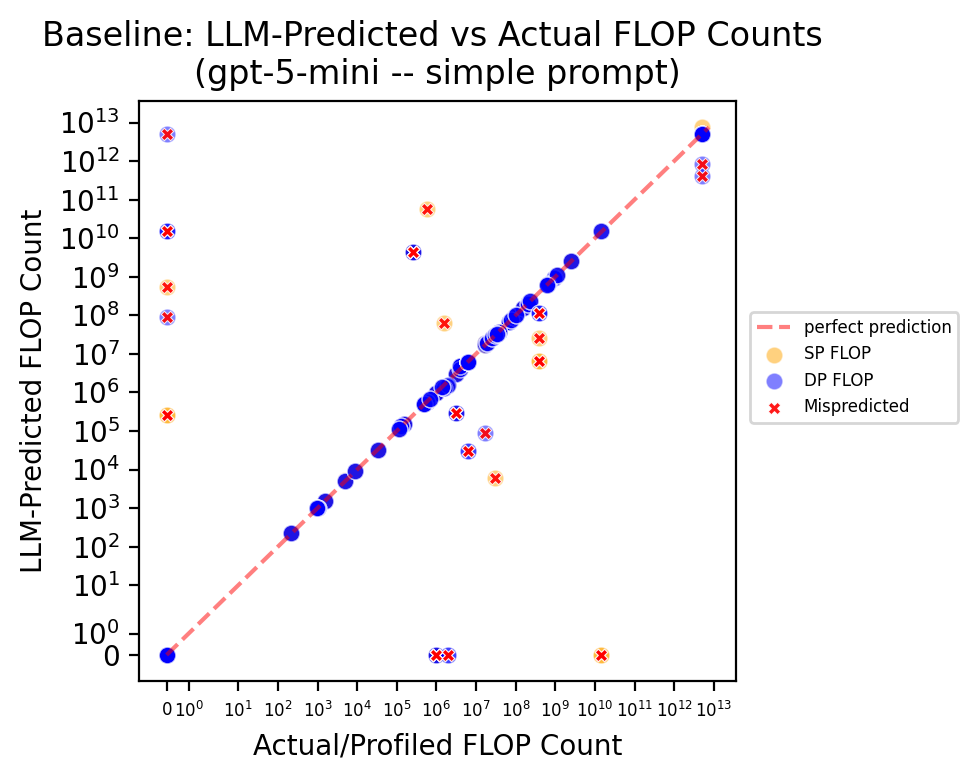

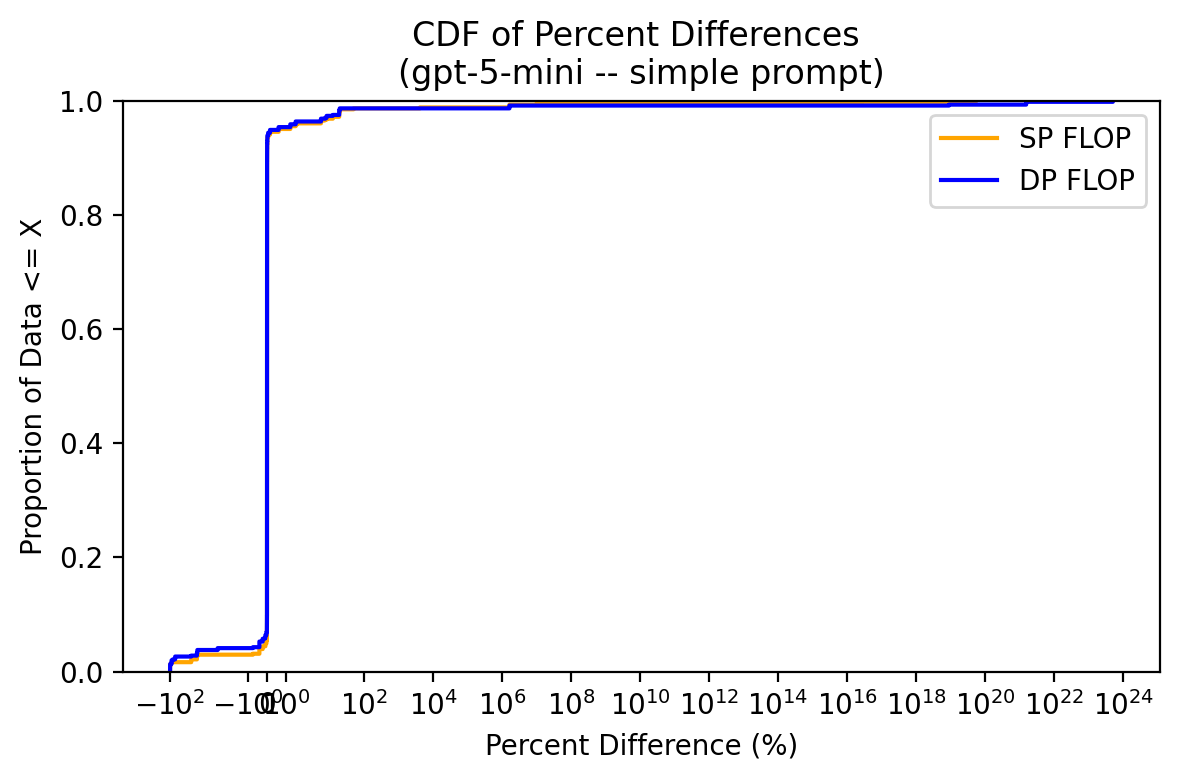

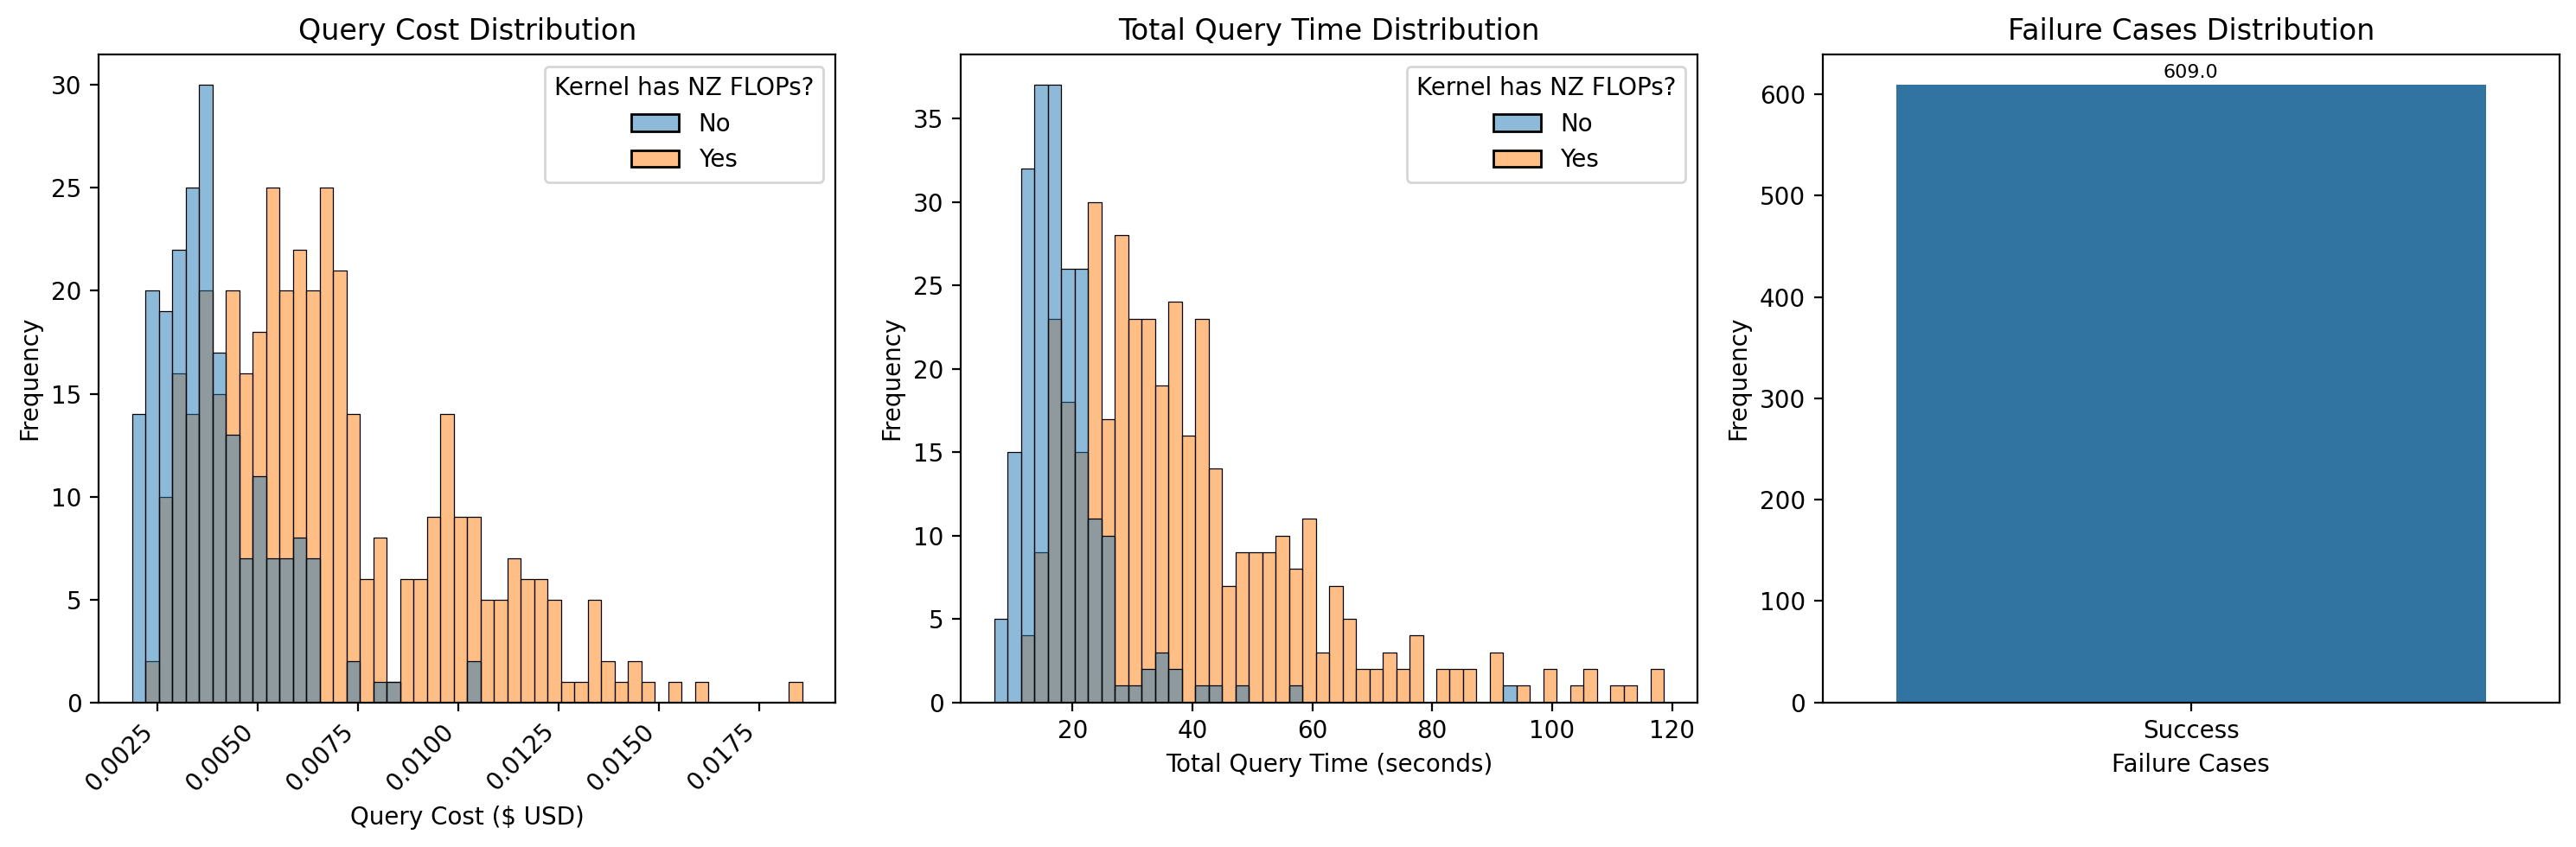

SP FLOP: 561 / 609 (92.12%) within +/- 1%
SP FLOP: 48 / 609 (7.88%) outside +/- 1%
DP FLOP: 556 / 609 (91.30%) within +/- 1%
DP FLOP: 53 / 609 (8.70%) outside +/- 1%


SP FLOP: 567 / 609 (93.10%) within +/- 5%
SP FLOP: 42 / 609 (6.90%) outside +/- 5%
DP FLOP: 564 / 609 (92.61%) within +/- 5%
DP FLOP: 45 / 609 (7.39%) outside +/- 5%


SP FLOP: 572 / 609 (93.92%) within +/- 10%
SP FLOP: 37 / 609 (6.08%) outside +/- 10%
DP FLOP: 570 / 609 (93.60%) within +/- 10%
DP FLOP: 39 / 609 (6.40%) outside +/- 10%


SP FLOP: 591 / 609 (97.04%) within +/- 50%
SP FLOP: 18 / 609 (2.96%) outside +/- 50%
DP FLOP: 585 / 609 (96.06%) within +/- 50%
DP FLOP: 24 / 609 (3.94%) outside +/- 50%


SP FLOP: 599 / 609 (98.36%) within +/- 100%
SP FLOP: 10 / 609 (1.64%) outside +/- 100%
DP FLOP: 601 / 609 (98.69%) within +/- 100%
DP FLOP: 8 / 609 (1.31%) outside +/- 100%






In [18]:
plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='full', show_erroneous=False)
plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='full', show_erroneous=True)
plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple', show_erroneous=False)
plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple', show_erroneous=True)